#Support Vector Machines

SVM es un algoritmo supervizado de Machine learning. Este algoritmo sirve para problemas de clasificación y de regresión, no obstante, son más comunes para resolver problemas de clasificación. La idea de este algoritmo es encontrar un hiperplano que nos ayude a divir de la mejor forma el data set entre las dos clases. Todo nuevo punto que cae de un lado del hiperplato "dibujado" tendrá un label determinado, si cae del otro lado, se le definirá otro valor. Hasta ahora suena simple, no obstante, la selección de dicho hiperplano es la real complejidad de este algoritmo. 
El hiperplano seleccionado deberá no sólo dividir al data set sino debe estar lo suficientemente alejado de los puntos más distantes de cada una de las clases.  
Los _support vectors_ o vectores soporte son los puntos de los datos más cercanos al hiperplano.  
El espacio existente entre el hiperplano y los puntos más cercanos, se denomina margen. La idea es encontrar un hiperplano que mejore la distancia de los márgenes para que cuando se quiera clasificar datos nuevamente los mismos exista el menor error posible.  
![img](https://miro.medium.com/max/575/1*6Om-ckghr9wdgBr0h8w5tw.png)

En la imagen anterior, podemos ver que ambas rectas pueden ser posibles soluciones ya que dividen el dataset de perfecto modo.  
Mirando la figura, la linea púrpura es la que posee los datos más alejados comparados con la línea verde.  
![](https://miro.medium.com/max/875/1*_wcGoFLpRaVqtrv2LzfcQQ.png)

Los márgenes duros o _hard margins_ fse utilizan para que ninguna clasificación errónea sea permitida en el modelo (se da cuando los dataset son realmente linealmente separables). Para poder permitir estos errores, existe una forma para penalizar las las clasificaciones erróneas para poder así controlar la cantidad de errores que puede soportar el algoritmo. Existe un hiperparámetro en el algoritmo denominado C, que controla esta penalidad, a mayor grande, mayor es la penalidad que se le dará a una clasificación errónea, más chico, será menor la penalidad.  
Cuando se permiten clasificaciones erróneas, los márgenes se los denominan márgenes suaves o _soft margins_. 

La distancia entre entre las observaciones y el hiperplano, se calcula como la distancia perpendicular de cada obsercación a dicho hiperplano.  
Como se menciona anteriormente, se pueden encontrar infinitos hiperplanos y cada hiperplano debería ser comparado contra todas las observaciones para poder obtener el de mayor margen. Por tal motivo se utilizan métodos de optimización y así lograr que el problema sea computacionalmente solucionado.  
En la gran mayoría de los problemas de la vida real, no existe una forma de separarlos linealmente, ya que no existe esta posibilidad hay herramientas que ayudan al SVM a poder resolver el problema en cuestion.  


### Kernels
En muchos casos, no es posible a priori realizar una separación lineal del espacio muestral, por tal motivo surgen algunos _trucos_ que ayudan a poder generar esta transformación. Estas transformaciones son generadas por una función denominada Kernel (K). En pocas palabras se devuelve el resultado de un dot product entre dos vectores creando un nuevo espacio dimensional distinto al original. Este nuevo espacio muestral nos ayuda a lograr dividir los datos en sus etiquetas. A esta transformación, se la denomina _kernel tricks_.  
![](https://miro.medium.com/max/875/1*NwhqamsvzBkUlYwSAubv5g.png)


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from google.colab import drive
import os

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve



### Monto la carpeta de Drive

In [3]:
#Levanto drive para poder almacenar los archivos
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


### Levanto la base 

In [4]:
data = pd.read_csv("{}/casosCovidProcesada.txt".format(contentFolder), sep=";")
data1 = data.sample(frac=0.05, random_state=1)

In [6]:
data1.groupby("fallecido").size() / len(data1)

fallecido
0    0.990868
1    0.009132
dtype: float64

In [7]:
data.groupby("fallecido").size() / len(data)

fallecido
0    0.990844
1    0.009156
dtype: float64

In [8]:
data2 = data.loc[~data.index.isin(data1.index)]

In [9]:
data2.groupby("fallecido").size() / len(data2)

fallecido
0    0.990842
1    0.009158
dtype: float64

In [10]:
X = data1.drop(columns = ["id_evento_caso", "fallecido"])
Y = data1.fallecido
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [11]:
probabilities = data.loc[X_test.index][["fallecido"]]

### Creo un dataset con la parte extra que no se uso para entrenar los modelos

### Documentación de Scikit Learn

*La* documentación de la implementación del SVC de Sklearn se encuentra [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

### Entreno el modelo

### Kernel Lineal

In [ ]:
svclassifier = SVC(kernel='linear', probability = True).fit(X_train, y_train)

### Obtengo las probabilidades
Con el modelo entrenado, obtengo las probabilidades de éxito (aquello que marqué cómo 1) de la base de test. Para ello uso la función predict_proba() del modelo creado

In [ ]:
svclassifierProbsLinear = svclassifier.predict_proba(X_test)[:,-1]
probabilities["linear"] = svclassifierProbsLinear

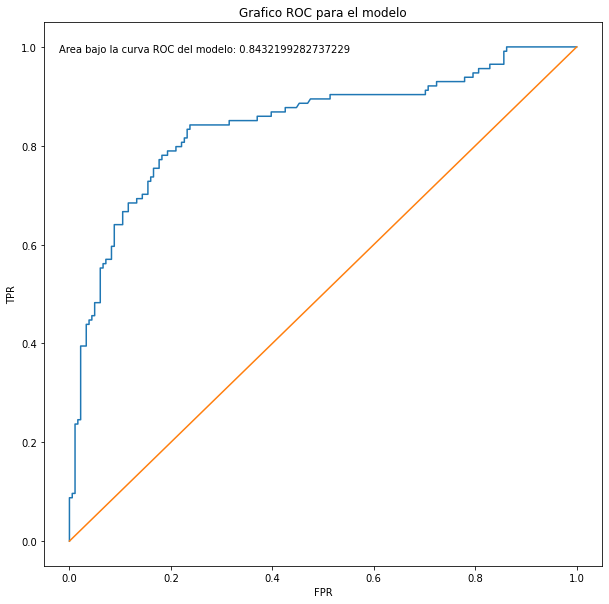

In [ ]:
score = "linear"
areaBajoCurvaRoc = roc_auc_score(probabilities.Survived, probabilities[score])
fpr, tpr, _ = roc_curve(probabilities.Survived, probabilities[score])
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()

In [ ]:
score = "linear"
probabilities['{}decile'.format(score)] = pd.qcut(probabilities[score], 10, labels=False)
measures = probabilities.groupby('{}decile'.format(score)).agg({"Survived": ["sum", "count"]})
measures.columns = ["Survived", "Cases"]
measures["notSurvived"] = measures["Cases"]-measures["Survived"]
measures["% not Survived"] = (measures["notSurvived"] / len(probabilities[probabilities.Survived == 0])).round(2)
measures["% Survived"] = (measures["Survived"] / len(X_test[probabilities.Survived == 1])).round(2)
measures = measures.sort_index(ascending = False)
a = measures[["% not Survived", "% Survived"]]\
                .cumsum()\
                .rename(columns={"% not Survived": "% not Survived cum.", 
                                 "% Survived": "% Survived cum."})

measures = measures.join(a)
measures

,Survived,Cases,notSurvived,% not Survived,% Survived,% not Survived cum.,% Survived cum.
lineardecile,,,,,,,
9,27,30,3,0.02,0.24,0.02,0.24
8,24,29,5,0.03,0.21,0.05,0.45
7,22,30,8,0.04,0.19,0.09,0.64
6,13,29,16,0.09,0.11,0.18,0.75
5,10,29,19,0.10,0.09,0.28,0.84
4,4,30,26,0.14,0.04,0.42,0.88
3,3,29,26,0.14,0.03,0.56,0.91
2,2,30,28,0.15,0.02,0.71,0.93
1,5,29,24,0.13,0.04,0.84,0.97


### Kernel Polinómico
La diferencia con el kernel lineal, es que la relación entre las variables independientes y las variables dependientes siguen una forma de polinomio de grado N.  
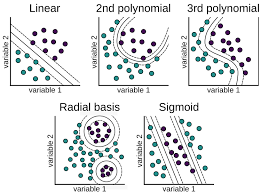


In [ ]:
svclassifierPoli = SVC(kernel='poly', probability = True, degree = 3).fit(X_train, y_train)

In [ ]:
svclassifierProbsPoli = svclassifierPoli.predict_proba(X_test)[:,-1]
probabilities["poli"] = svclassifierProbsPoli

In [ ]:
probabilities

,Survived,linear,lineardecile,poli
709,1,0.159087,3,0.345841
439,1,0.608595,6,0.350103
840,1,0.695831,7,0.358927
720,0,0.170195,4,0.377065
39,0,0.157771,3,0.347515
...,...,...,...,...
715,1,0.789772,9,0.371041
525,0,0.733152,8,0.379451
381,1,0.150796,2,0.370480
140,0,0.155268,3,0.347205


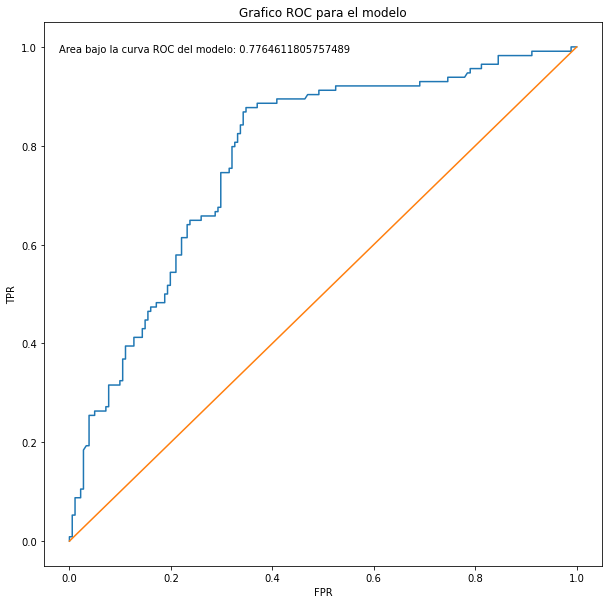

In [ ]:
score = "poli"
areaBajoCurvaRoc = roc_auc_score(probabilities.Survived, probabilities[score])
fpr, tpr, _ = roc_curve(probabilities.Survived, probabilities[score])
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()

In [ ]:
svclassifierRadial = SVC(kernel='rbf', probability = True).fit(X_train, y_train)

In [ ]:
svclassifierProbsRadial = svclassifierRadial.predict_proba(X_test)[:,-1]
probabilities["radial"] = svclassifierProbsRadial

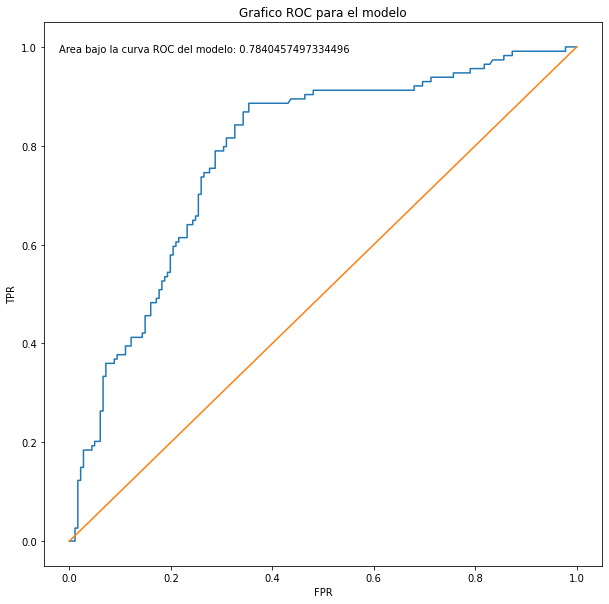

In [ ]:
score = "radial"
areaBajoCurvaRoc = roc_auc_score(probabilities.Survived, probabilities[score])
fpr, tpr, _ = roc_curve(probabilities.Survived, probabilities[score])
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()